# BMC_OR: ES(1+1) Random Optimization

This notebook implements **ES(1+1) with Random Optimization** for the BMC_OR dataset using:
1. **EfficientNetB0**
2. **ResNet50**

## Random Optimization Approach
- Start with **random hyperparameters** (not baseline)
- ES(1+1) explores from random starting points
- 1/5 success rule adapts mutation step sizes

## Dataset: BMC_OR
- Training: ~737 images (22 volume classes)
- Testing: ~107 images (11 volume classes)
- Volume range: 100-610 mL
- Note: FV and BV images are mixed in the same folder (not in subfolders)

In [1]:
# ============================================================
# SETUP: IMPORTS AND COMMON FUNCTIONS
# ============================================================
import os
import time
import numpy as np
import copy
import gc
import json
import matplotlib.pyplot as plt
from PIL import Image
from datetime import datetime
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import models

# Random seed
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"PyTorch: {torch.__version__}, Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# ============================================================
# PATHS
# ============================================================
TRAIN_BASE = "/data1/Siri/MeasuringCup/BMC_OR/OR_training"
TEST_BASE = "/data1/Siri/MeasuringCup/BMC_OR/OR_testing"
OUTPUT_DIR = "/data1/Siri/MeasuringCup/BMC_OR/code"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Pretrained weights path
cache_dir = os.path.expanduser('~/.cache/torch/hub/checkpoints')
os.makedirs(cache_dir, exist_ok=True)

# ============================================================
# DATA LOADING FUNCTIONS
# ============================================================
def collect_images_or(base_folder):
    """Collect images from BMC_OR - FV/BV images mixed in same folder."""
    X_paths, Y = [], []
    for vol_folder in sorted(os.listdir(base_folder)):
        if not vol_folder.isdigit():
            continue
        vol_path = os.path.join(base_folder, vol_folder)
        if not os.path.isdir(vol_path):
            continue
        # In BMC_OR, images are directly in volume folder (no BV/FV subfolders)
        for img_file in sorted(os.listdir(vol_path)):
            if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                X_paths.append(os.path.join(vol_path, img_file))
                Y.append(int(vol_folder))
    return X_paths, np.array(Y, dtype=np.float32)

def load_images(paths, target_size=(224, 224)):
    """Load and normalize images to [0,1]."""
    X = []
    for p in paths:
        img = Image.open(p).convert('RGB').resize(target_size, Image.BILINEAR)
        X.append(np.array(img, dtype=np.float32) / 255.0)
    return np.array(X, dtype=np.float32)

# ============================================================
# LOAD DATA
# ============================================================
print("\nLoading BMC_OR data...")
train_paths, Y_train_full = collect_images_or(TRAIN_BASE)
test_paths, Y_test = collect_images_or(TEST_BASE)

X_train_full = load_images(train_paths)
X_test = load_images(test_paths)

# Train/Val split
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train_full, Y_train_full, test_size=0.15, random_state=SEED,
    stratify=Y_train_full.astype(int)
)

print(f"Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}")
print(f"Volume range: {Y_train.min():.0f} - {Y_train.max():.0f} mL")

# Test loader (shared)
X_test_t = torch.tensor(X_test.transpose(0, 3, 1, 2), dtype=torch.float32)
Y_test_t = torch.tensor(Y_test, dtype=torch.float32)
test_loader = DataLoader(TensorDataset(X_test_t, Y_test_t), batch_size=16, shuffle=False)

PyTorch: 2.1.0+cu121, Device: cuda
GPU: NVIDIA A100 80GB PCIe

Loading BMC_OR data...
Train: 674, Val: 120, Test: 107
Volume range: 100 - 610 mL


In [2]:
# ============================================================
# ES(1+1) CONFIGURATION AND HELPER FUNCTIONS
# ============================================================

# ES Configuration
ES_CONFIG = {
    'max_generations': 30,
    'stagnation_limit': 15,
    'success_window': 10,
    'epochs_per_eval': 20,
    'patience_per_eval': 6,
    'c': 0.82,
}

# Parameter bounds
PARAM_BOUNDS = {
    'neurons': (32, 512),
    'dropout': (0.1, 0.5),
    'learning_rate': (1e-5, 1e-2),
    'freeze_ratio': (0.0, 0.7),
    'batch_size': [8, 16, 32],
    'num_hidden_layers': [1, 2],
    'activation': ['relu', 'leaky_relu', 'gelu'],
}

# Initial step sizes
INITIAL_STEP_SIZES = {
    'neurons': 50.0,
    'dropout': 0.1,
    'learning_rate': 0.5,
    'freeze_ratio': 0.1,
}

def random_params():
    """Generate RANDOM hyperparameters within bounds."""
    return {
        'neurons': int(np.random.randint(PARAM_BOUNDS['neurons'][0], PARAM_BOUNDS['neurons'][1])),
        'dropout': float(np.random.uniform(PARAM_BOUNDS['dropout'][0], PARAM_BOUNDS['dropout'][1])),
        'learning_rate': float(10 ** np.random.uniform(
            np.log10(PARAM_BOUNDS['learning_rate'][0]), 
            np.log10(PARAM_BOUNDS['learning_rate'][1])
        )),
        'freeze_ratio': float(np.random.uniform(PARAM_BOUNDS['freeze_ratio'][0], PARAM_BOUNDS['freeze_ratio'][1])),
        'batch_size': int(np.random.choice(PARAM_BOUNDS['batch_size'])),
        'num_hidden_layers': int(np.random.choice(PARAM_BOUNDS['num_hidden_layers'])),
        'activation': str(np.random.choice(PARAM_BOUNDS['activation'])),
    }

def mutate_params(parent, step_sizes):
    """Mutate hyperparameters using Gaussian perturbation."""
    child = copy.deepcopy(parent)
    
    child['neurons'] = int(np.clip(
        child['neurons'] + np.random.normal(0, step_sizes['neurons']),
        PARAM_BOUNDS['neurons'][0], PARAM_BOUNDS['neurons'][1]
    ))
    child['dropout'] = float(np.clip(
        child['dropout'] + np.random.normal(0, step_sizes['dropout']),
        PARAM_BOUNDS['dropout'][0], PARAM_BOUNDS['dropout'][1]
    ))
    log_lr = np.log10(parent['learning_rate'])
    log_lr_new = np.clip(
        log_lr + np.random.normal(0, step_sizes['learning_rate']),
        np.log10(PARAM_BOUNDS['learning_rate'][0]),
        np.log10(PARAM_BOUNDS['learning_rate'][1])
    )
    child['learning_rate'] = float(10 ** log_lr_new)
    child['freeze_ratio'] = float(np.clip(
        child['freeze_ratio'] + np.random.normal(0, step_sizes['freeze_ratio']),
        PARAM_BOUNDS['freeze_ratio'][0], PARAM_BOUNDS['freeze_ratio'][1]
    ))
    
    if np.random.random() < 0.2:
        child['batch_size'] = int(np.random.choice(PARAM_BOUNDS['batch_size']))
    if np.random.random() < 0.15:
        child['num_hidden_layers'] = int(np.random.choice(PARAM_BOUNDS['num_hidden_layers']))
    if np.random.random() < 0.1:
        child['activation'] = str(np.random.choice(PARAM_BOUNDS['activation']))
    
    return child

def apply_one_fifth_rule(success_rate, step_sizes, c=0.82):
    """Apply 1/5 success rule."""
    factor = 1.0 / c if success_rate > 0.2 else c
    return {k: np.clip(v * factor, INITIAL_STEP_SIZES[k] * 0.1, INITIAL_STEP_SIZES[k] * 3.0) 
            for k, v in step_sizes.items()}

print("ES helper functions defined.")

ES helper functions defined.


In [3]:
# ============================================================
# EFFICIENTNETB0 - ES(1+1) WITH RANDOM OPTIMIZATION
# ============================================================
print("="*70)
print("EFFICIENTNETB0 - ES(1+1) WITH RANDOM OPTIMIZATION")
print("="*70)

# Download EfficientNet weights if needed
efficientnet_weights = os.path.join(cache_dir, 'efficientnet_b0.pth')
if not os.path.exists(efficientnet_weights):
    print("Downloading EfficientNetB0 weights...")
    torch.hub.download_url_to_file(
        "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth",
        efficientnet_weights, hash_prefix=None
    )

class EfficientNetRegressor(nn.Module):
    def __init__(self, params):
        super().__init__()
        neurons = int(params.get('neurons', 128))
        dropout = float(params.get('dropout', 0.3))
        freeze_ratio = float(params.get('freeze_ratio', 0.0))
        num_hidden = int(params.get('num_hidden_layers', 1))
        activation = str(params.get('activation', 'relu'))
        
        act_fn = {'relu': nn.ReLU(), 'leaky_relu': nn.LeakyReLU(0.1), 'gelu': nn.GELU()}.get(activation, nn.ReLU())
        
        self.backbone = models.efficientnet_b0(weights=None)
        if os.path.exists(efficientnet_weights):
            self.backbone.load_state_dict(torch.load(efficientnet_weights, map_location='cpu'))
        
        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Identity()
        
        if freeze_ratio > 0:
            all_params = list(self.backbone.parameters())
            for i, p in enumerate(all_params):
                p.requires_grad = (i >= int(len(all_params) * freeze_ratio))
        
        layers = []
        curr = in_features
        for _ in range(num_hidden):
            layers.extend([nn.Dropout(dropout), nn.Linear(curr, neurons), copy.deepcopy(act_fn)])
            curr = neurons
        layers.extend([nn.Dropout(dropout/2), nn.Linear(curr, 1)])
        self.head = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.head(self.backbone(x)).squeeze(-1)

def train_efficientnet(params, X_tr, Y_tr, X_vl, Y_vl, epochs=20, patience=6, verbose=False):
    """Train EfficientNet and return validation MAE."""
    try:
        X_tr_t = torch.tensor(X_tr.transpose(0,3,1,2), dtype=torch.float32)
        X_vl_t = torch.tensor(X_vl.transpose(0,3,1,2), dtype=torch.float32)
        Y_tr_t = torch.tensor(Y_tr, dtype=torch.float32).unsqueeze(1)
        Y_vl_t = torch.tensor(Y_vl, dtype=torch.float32).unsqueeze(1)
        
        bs = int(params.get('batch_size', 16))
        train_loader = DataLoader(TensorDataset(X_tr_t, Y_tr_t), batch_size=bs, shuffle=True)
        val_loader = DataLoader(TensorDataset(X_vl_t, Y_vl_t), batch_size=bs, shuffle=False)
        
        model = EfficientNetRegressor(params).to(device)
        criterion = nn.L1Loss()
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=params['learning_rate'])
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3)
        
        best_mae, patience_cnt = float('inf'), 0
        for epoch in range(epochs):
            model.train()
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                loss = criterion(model(xb), yb.squeeze())
                loss.backward()
                optimizer.step()
            
            model.eval()
            val_loss = sum(criterion(model(xb.to(device)), yb.to(device).squeeze()).item() * len(xb) 
                          for xb, yb in val_loader) / len(Y_vl)
            scheduler.step(val_loss)
            
            if val_loss < best_mae:
                best_mae, patience_cnt = val_loss, 0
            else:
                patience_cnt += 1
                if patience_cnt >= patience:
                    break
        
        del model; gc.collect(); torch.cuda.empty_cache()
        return best_mae
    except Exception as e:
        print(f"Error: {e}")
        gc.collect(); torch.cuda.empty_cache()
        return float('inf')

# ES(1+1) Loop for EfficientNet
print(f"\nStarting ES(1+1) with RANDOM initialization...")
eff_start = time.time()

step_sizes = INITIAL_STEP_SIZES.copy()
parent = random_params()  # RANDOM START
print(f"Random initial params: neurons={parent['neurons']}, dropout={parent['dropout']:.3f}, lr={parent['learning_rate']:.2e}")

parent_mae = train_efficientnet(parent, X_train, Y_train, X_val, Y_val, ES_CONFIG['epochs_per_eval'], ES_CONFIG['patience_per_eval'])
print(f"Initial MAE: {parent_mae:.4f}")

eff_best_params, eff_best_mae = copy.deepcopy(parent), parent_mae
success_history, stagnation = [], 0

print(f"\n{'Gen':>3} | {'Parent':>8} | {'Child':>8} | {'Best':>8} | {'Status':>10}")
print("-" * 50)

for gen in range(1, ES_CONFIG['max_generations'] + 1):
    child = mutate_params(parent, step_sizes)
    child_mae = train_efficientnet(child, X_train, Y_train, X_val, Y_val, ES_CONFIG['epochs_per_eval'], ES_CONFIG['patience_per_eval'])
    
    if child_mae < parent_mae:
        parent, parent_mae = copy.deepcopy(child), child_mae
        success, status, stagnation = True, "*BETTER*", 0
        if child_mae < eff_best_mae:
            eff_best_mae, eff_best_params = child_mae, copy.deepcopy(child)
            status = "**BEST**"
    else:
        success, status = False, ""
        stagnation += 1
    
    success_history.append(success)
    if gen % ES_CONFIG['success_window'] == 0:
        sr = sum(success_history[-ES_CONFIG['success_window']:]) / ES_CONFIG['success_window']
        step_sizes = apply_one_fifth_rule(sr, step_sizes)
    
    print(f"{gen:3d} | {parent_mae:8.2f} | {child_mae:8.2f} | {eff_best_mae:8.2f} | {status:>10}")
    
    if stagnation >= ES_CONFIG['stagnation_limit']:
        print(f"Stagnation limit reached.")
        break

eff_time = time.time() - eff_start

# Final training with best params
print(f"\nTraining final EfficientNet model...")
final_eff = EfficientNetRegressor(eff_best_params).to(device)
X_full_t = torch.tensor(X_train_full.transpose(0,3,1,2), dtype=torch.float32)
Y_full_t = torch.tensor(Y_train_full, dtype=torch.float32).unsqueeze(1)
train_loader = DataLoader(TensorDataset(X_full_t, Y_full_t), batch_size=eff_best_params['batch_size'], shuffle=True)

optimizer = optim.Adam(filter(lambda p: p.requires_grad, final_eff.parameters()), lr=eff_best_params['learning_rate'])
criterion = nn.L1Loss()

for epoch in range(30):
    final_eff.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        criterion(final_eff(xb), yb.squeeze()).backward()
        optimizer.step()

# Evaluate on test
final_eff.eval()
eff_preds, eff_actuals = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        eff_preds.extend(final_eff(xb.to(device)).cpu().numpy())
        eff_actuals.extend(yb.numpy())

eff_preds, eff_actuals = np.array(eff_preds), np.array(eff_actuals)
eff_test_mae = np.mean(np.abs(eff_actuals - eff_preds))
eff_accuracy = np.mean(100 * (1 - np.abs(eff_actuals - eff_preds) / eff_actuals))

print(f"\n" + "="*50)
print(f"EFFICIENTNETB0 RESULTS")
print(f"="*50)
print(f"Best ES Val MAE: {eff_best_mae:.4f} mL")
print(f"Test MAE: {eff_test_mae:.4f} mL")
print(f"Test Accuracy: {eff_accuracy:.2f}%")
print(f"Time: {eff_time/60:.2f} min")
print(f"\nBest Params: neurons={eff_best_params['neurons']}, dropout={eff_best_params['dropout']:.3f}, "
      f"lr={eff_best_params['learning_rate']:.2e}, freeze={eff_best_params['freeze_ratio']:.2f}")

# Save
torch.save(final_eff.state_dict(), os.path.join(OUTPUT_DIR, 'efficientnet_es_random.pth'))
del final_eff; gc.collect(); torch.cuda.empty_cache()

EFFICIENTNETB0 - ES(1+1) WITH RANDOM OPTIMIZATION

Starting ES(1+1) with RANDOM initialization...
Random initial params: neurons=134, dropout=0.419, lr=3.55e-05
Initial MAE: 16.4019

Gen |   Parent |    Child |     Best |     Status
--------------------------------------------------
  1 |    16.40 |   282.31 |    16.40 |           
  2 |    16.40 |    49.67 |    16.40 |           
  3 |    16.40 |   174.81 |    16.40 |           
  4 |    16.40 |   204.72 |    16.40 |           
  5 |    16.40 |   215.27 |    16.40 |           
  6 |    16.40 |   265.31 |    16.40 |           
  7 |    16.40 |   224.24 |    16.40 |           
  8 |    12.64 |    12.64 |    12.64 |   **BEST**
  9 |    12.64 |    14.94 |    12.64 |           
 10 |     9.03 |     9.03 |     9.03 |   **BEST**
 11 |     9.03 |    60.58 |     9.03 |           
 12 |     7.39 |     7.39 |     7.39 |   **BEST**
 13 |     7.39 |    16.47 |     7.39 |           
 14 |     7.39 |     7.55 |     7.39 |           
 15 |     7.39 |

In [4]:
# ============================================================
# RESNET50 - ES(1+1) WITH RANDOM OPTIMIZATION
# ============================================================
print("="*70)
print("RESNET50 - ES(1+1) WITH RANDOM OPTIMIZATION")
print("="*70)

class ResNet50Regressor(nn.Module):
    def __init__(self, params):
        super().__init__()
        neurons = int(params.get('neurons', 128))
        dropout = float(params.get('dropout', 0.3))
        freeze_ratio = float(params.get('freeze_ratio', 0.0))
        num_hidden = int(params.get('num_hidden_layers', 1))
        activation = str(params.get('activation', 'relu'))
        
        act_fn = {'relu': nn.ReLU(), 'leaky_relu': nn.LeakyReLU(0.1), 'gelu': nn.GELU()}.get(activation, nn.ReLU())
        
        # Load pretrained ResNet50
        self.backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        
        if freeze_ratio > 0:
            all_params = list(self.backbone.parameters())
            for i, p in enumerate(all_params):
                p.requires_grad = (i >= int(len(all_params) * freeze_ratio))
        
        layers = []
        curr = in_features
        for _ in range(num_hidden):
            layers.extend([nn.Dropout(dropout), nn.Linear(curr, neurons), copy.deepcopy(act_fn)])
            curr = neurons
        layers.extend([nn.Dropout(dropout/2), nn.Linear(curr, 1)])
        self.head = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.head(self.backbone(x)).squeeze(-1)

def train_resnet(params, X_tr, Y_tr, X_vl, Y_vl, epochs=20, patience=6, verbose=False):
    """Train ResNet50 and return validation MAE."""
    try:
        X_tr_t = torch.tensor(X_tr.transpose(0,3,1,2), dtype=torch.float32)
        X_vl_t = torch.tensor(X_vl.transpose(0,3,1,2), dtype=torch.float32)
        Y_tr_t = torch.tensor(Y_tr, dtype=torch.float32).unsqueeze(1)
        Y_vl_t = torch.tensor(Y_vl, dtype=torch.float32).unsqueeze(1)
        
        bs = int(params.get('batch_size', 16))
        train_loader = DataLoader(TensorDataset(X_tr_t, Y_tr_t), batch_size=bs, shuffle=True)
        val_loader = DataLoader(TensorDataset(X_vl_t, Y_vl_t), batch_size=bs, shuffle=False)
        
        model = ResNet50Regressor(params).to(device)
        criterion = nn.L1Loss()
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=params['learning_rate'])
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3)
        
        best_mae, patience_cnt = float('inf'), 0
        for epoch in range(epochs):
            model.train()
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                loss = criterion(model(xb), yb.squeeze())
                loss.backward()
                optimizer.step()
            
            model.eval()
            val_loss = sum(criterion(model(xb.to(device)), yb.to(device).squeeze()).item() * len(xb) 
                          for xb, yb in val_loader) / len(Y_vl)
            scheduler.step(val_loss)
            
            if val_loss < best_mae:
                best_mae, patience_cnt = val_loss, 0
            else:
                patience_cnt += 1
                if patience_cnt >= patience:
                    break
        
        del model; gc.collect(); torch.cuda.empty_cache()
        return best_mae
    except Exception as e:
        print(f"Error: {e}")
        gc.collect(); torch.cuda.empty_cache()
        return float('inf')

# ES(1+1) Loop for ResNet50
print(f"\nStarting ES(1+1) with RANDOM initialization...")
res_start = time.time()

step_sizes = INITIAL_STEP_SIZES.copy()
parent = random_params()  # RANDOM START
print(f"Random initial params: neurons={parent['neurons']}, dropout={parent['dropout']:.3f}, lr={parent['learning_rate']:.2e}")

parent_mae = train_resnet(parent, X_train, Y_train, X_val, Y_val, ES_CONFIG['epochs_per_eval'], ES_CONFIG['patience_per_eval'])
print(f"Initial MAE: {parent_mae:.4f}")

res_best_params, res_best_mae = copy.deepcopy(parent), parent_mae
success_history, stagnation = [], 0

print(f"\n{'Gen':>3} | {'Parent':>8} | {'Child':>8} | {'Best':>8} | {'Status':>10}")
print("-" * 50)

for gen in range(1, ES_CONFIG['max_generations'] + 1):
    child = mutate_params(parent, step_sizes)
    child_mae = train_resnet(child, X_train, Y_train, X_val, Y_val, ES_CONFIG['epochs_per_eval'], ES_CONFIG['patience_per_eval'])
    
    if child_mae < parent_mae:
        parent, parent_mae = copy.deepcopy(child), child_mae
        success, status, stagnation = True, "*BETTER*", 0
        if child_mae < res_best_mae:
            res_best_mae, res_best_params = child_mae, copy.deepcopy(child)
            status = "**BEST**"
    else:
        success, status = False, ""
        stagnation += 1
    
    success_history.append(success)
    if gen % ES_CONFIG['success_window'] == 0:
        sr = sum(success_history[-ES_CONFIG['success_window']:]) / ES_CONFIG['success_window']
        step_sizes = apply_one_fifth_rule(sr, step_sizes)
    
    print(f"{gen:3d} | {parent_mae:8.2f} | {child_mae:8.2f} | {res_best_mae:8.2f} | {status:>10}")
    
    if stagnation >= ES_CONFIG['stagnation_limit']:
        print(f"Stagnation limit reached.")
        break

res_time = time.time() - res_start

# Final training with best params
print(f"\nTraining final ResNet50 model...")
final_res = ResNet50Regressor(res_best_params).to(device)
train_loader = DataLoader(TensorDataset(X_full_t, Y_full_t), batch_size=res_best_params['batch_size'], shuffle=True)

optimizer = optim.Adam(filter(lambda p: p.requires_grad, final_res.parameters()), lr=res_best_params['learning_rate'])
criterion = nn.L1Loss()

for epoch in range(30):
    final_res.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        criterion(final_res(xb), yb.squeeze()).backward()
        optimizer.step()

# Evaluate on test
final_res.eval()
res_preds, res_actuals = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        res_preds.extend(final_res(xb.to(device)).cpu().numpy())
        res_actuals.extend(yb.numpy())

res_preds, res_actuals = np.array(res_preds), np.array(res_actuals)
res_test_mae = np.mean(np.abs(res_actuals - res_preds))
res_accuracy = np.mean(100 * (1 - np.abs(res_actuals - res_preds) / res_actuals))

print(f"\n" + "="*50)
print(f"RESNET50 RESULTS")
print(f"="*50)
print(f"Best ES Val MAE: {res_best_mae:.4f} mL")
print(f"Test MAE: {res_test_mae:.4f} mL")
print(f"Test Accuracy: {res_accuracy:.2f}%")
print(f"Time: {res_time/60:.2f} min")
print(f"\nBest Params: neurons={res_best_params['neurons']}, dropout={res_best_params['dropout']:.3f}, "
      f"lr={res_best_params['learning_rate']:.2e}, freeze={res_best_params['freeze_ratio']:.2f}")

# Save
torch.save(final_res.state_dict(), os.path.join(OUTPUT_DIR, 'resnet50_es_random.pth'))
del final_res; gc.collect(); torch.cuda.empty_cache()

RESNET50 - ES(1+1) WITH RANDOM OPTIMIZATION

Starting ES(1+1) with RANDOM initialization...
Random initial params: neurons=311, dropout=0.184, lr=1.03e-03
Initial MAE: 6.5023

Gen |   Parent |    Child |     Best |     Status
--------------------------------------------------
  1 |     6.50 |     6.64 |     6.50 |           
  2 |     5.76 |     5.76 |     5.76 |   **BEST**
  3 |     5.76 |    10.94 |     5.76 |           
  4 |     5.47 |     5.47 |     5.47 |   **BEST**
  5 |     4.64 |     4.64 |     4.64 |   **BEST**
  6 |     4.64 |     5.90 |     4.64 |           
  7 |     4.64 |     7.24 |     4.64 |           
  8 |     4.64 |     8.05 |     4.64 |           
  9 |     4.64 |     7.14 |     4.64 |           
 10 |     4.64 |     7.18 |     4.64 |           
 11 |     4.64 |     7.60 |     4.64 |           
 12 |     4.64 |     8.74 |     4.64 |           
 13 |     4.64 |    13.90 |     4.64 |           
 14 |     4.64 |     6.34 |     4.64 |           
 15 |     4.64 |    11.

In [5]:
# ============================================================
# FINAL COMPARISON
# ============================================================
print("\n" + "#"*70)
print("#" + " "*68 + "#")
print("#" + "  BMC_OR: ES(1+1) RANDOM OPTIMIZATION - FINAL COMPARISON  ".center(68) + "#")
print("#" + " "*68 + "#")
print("#"*70)
print("#" + " "*68 + "#")
print("#" + f"  EFFICIENTNETB0:                                              ".ljust(68) + "#")
print("#" + f"    Test MAE: {eff_test_mae:.4f} mL                                        ".ljust(68) + "#")
print("#" + f"    Accuracy: {eff_accuracy:.2f}%                                          ".ljust(68) + "#")
print("#" + f"    Time: {eff_time/60:.2f} min                                            ".ljust(68) + "#")
print("#" + " "*68 + "#")
print("#" + f"  RESNET50:                                                    ".ljust(68) + "#")
print("#" + f"    Test MAE: {res_test_mae:.4f} mL                                        ".ljust(68) + "#")
print("#" + f"    Accuracy: {res_accuracy:.2f}%                                          ".ljust(68) + "#")
print("#" + f"    Time: {res_time/60:.2f} min                                            ".ljust(68) + "#")
print("#" + " "*68 + "#")
print("#" + "-"*68 + "#")

winner = "EfficientNetB0" if eff_test_mae < res_test_mae else "ResNet50"
print("#" + f"  WINNER: {winner}                                              ".ljust(68) + "#")
print("#" + " "*68 + "#")
print("#"*70)

# Save comparison results
results = {
    'dataset': 'BMC_OR',
    'method': 'ES(1+1) Random Optimization',
    'efficientnet': {
        'params': eff_best_params,
        'val_mae': float(eff_best_mae),
        'test_mae': float(eff_test_mae),
        'accuracy': float(eff_accuracy),
        'time_min': float(eff_time/60)
    },
    'resnet50': {
        'params': res_best_params,
        'val_mae': float(res_best_mae),
        'test_mae': float(res_test_mae),
        'accuracy': float(res_accuracy),
        'time_min': float(res_time/60)
    },
    'winner': winner
}

with open(os.path.join(OUTPUT_DIR, 'es_random_comparison.json'), 'w') as f:
    json.dump(results, f, indent=2)

print(f"\nResults saved to: {OUTPUT_DIR}/es_random_comparison.json")
print(f"Models saved: efficientnet_es_random.pth, resnet50_es_random.pth")


######################################################################
#                                                                    #
#       BMC_OR: ES(1+1) RANDOM OPTIMIZATION - FINAL COMPARISON       #
#                                                                    #
######################################################################
#                                                                    #
#  EFFICIENTNETB0:                                                   #
#    Test MAE: 10.5316 mL                                            #
#    Accuracy: 96.74%                                                #
#    Time: 17.92 min                                                 #
#                                                                    #
#  RESNET50:                                                         #
#    Test MAE: 6.7104 mL                                             #
#    Accuracy: 97.52%                                                #
#    

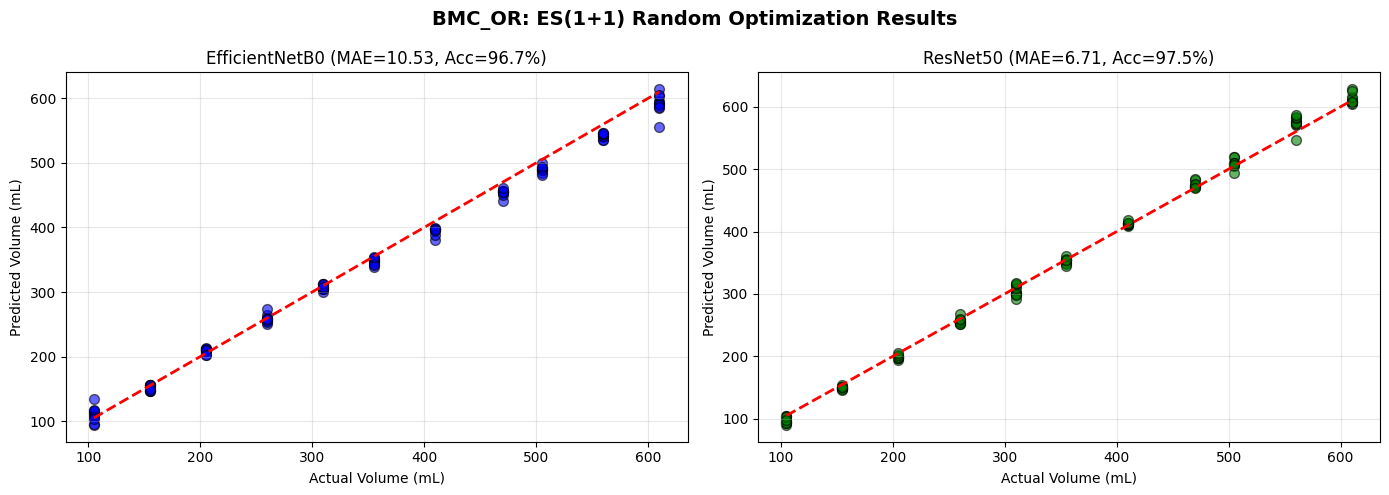

Plot saved: es_random_comparison.png


In [6]:
# ============================================================
# VISUALIZATION
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# EfficientNet predictions
ax1 = axes[0]
ax1.scatter(eff_actuals, eff_preds, alpha=0.6, c='blue', edgecolors='black', s=50)
ax1.plot([eff_actuals.min(), eff_actuals.max()], [eff_actuals.min(), eff_actuals.max()], 'r--', lw=2)
ax1.set_xlabel('Actual Volume (mL)')
ax1.set_ylabel('Predicted Volume (mL)')
ax1.set_title(f'EfficientNetB0 (MAE={eff_test_mae:.2f}, Acc={eff_accuracy:.1f}%)')
ax1.grid(True, alpha=0.3)

# ResNet predictions
ax2 = axes[1]
ax2.scatter(res_actuals, res_preds, alpha=0.6, c='green', edgecolors='black', s=50)
ax2.plot([res_actuals.min(), res_actuals.max()], [res_actuals.min(), res_actuals.max()], 'r--', lw=2)
ax2.set_xlabel('Actual Volume (mL)')
ax2.set_ylabel('Predicted Volume (mL)')
ax2.set_title(f'ResNet50 (MAE={res_test_mae:.2f}, Acc={res_accuracy:.1f}%)')
ax2.grid(True, alpha=0.3)

plt.suptitle('BMC_OR: ES(1+1) Random Optimization Results', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'es_random_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()
print(f"Plot saved: es_random_comparison.png")